# Test ENIGMA toolboox

https://enigma-toolbox.readthedocs.io/en/latest/pages/01.install/index.html \
general comment: we have installed the latest version of the enigma toolboox (still not stable)

## Hub susceptibility
### Cortical Hubs

In [9]:
# load cortical and subcortical connectivity matrices 
from enigmatoolbox.datasets import load_sc, load_fc
from nilearn import plotting 

sc_ctx, sc_ctx_labels, sc_sctx, sc_sctx_labels = load_sc() 
fc_ctx, fc_ctx_labels, fc_sctx, fc_sctx_labels = load_fc() 

# sc_plot = plotting.plot_matrix(sc_ctx, figure = (9,9), labels=sc_ctx_labels, vmax = 10, vmin = 0, cmap = 'Blues')
#fc_plot = plotting.plot_matrix(fc_ctx, figure = (9,9), labels=fc_ctx_labels, vmax = 0.8, vmin = 0, cmap = 'Reds')

In [10]:
import numpy as np 
from enigmatoolbox.plotting import plot_cortical
from enigmatoolbox.plotting import plot_subcortical
from enigmatoolbox.utils.parcellation import parcel_to_surface 

# compute weighted degree centrality measures from the connectivity data 
fc_ctx_dc = np.sum(fc_ctx, axis = 0)
sc_ctx_dc = np.sum(sc_ctx, axis = 0)

#map parcelled data to the surface 
fc_ctx_dc_fsa5 = parcel_to_surface(fc_ctx_dc, "aparc_fsa5") #try with schaefer 
sc_ctx_dc_fsa5 = parcel_to_surface(sc_ctx_dc, "aparc_fsa5")


In [4]:
#project the results on the surface brain
plot_cortical(array_name=fc_ctx_dc_fsa5, surface_name="fsa5", size=(800,400), cmap="Reds", color_bar=True, color_range=(20,30))
#plot_cortical(array_name=sc_ctx_dc_fsa5, surface_name="fsa5", size=(800,400), cmap="Blues", color_bar=True, color_range=(100,300))

: 

### Subcortical hubs 

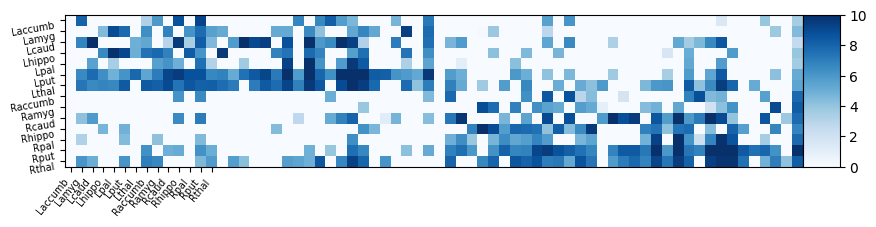

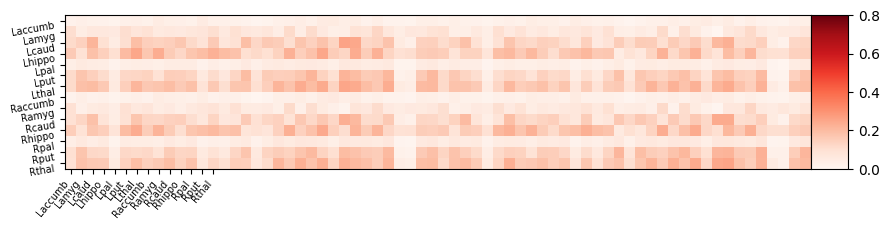

In [2]:
# plot subcortical connectivity matrices (data loaded previously)
ssc_plot = plotting.plot_matrix(sc_sctx, figure = (9,9), labels=sc_sctx_labels, vmax = 10, vmin = 0, cmap = 'Blues')
sfc_plot = plotting.plot_matrix(fc_sctx, figure = (9,9), labels=fc_sctx_labels, vmax = 0.8, vmin = 0, cmap = 'Reds')

In [11]:
#compute weighted degree centrality measures from the connectivity data 
fc_sctx_dc = np.sum(fc_sctx, axis =1)
sc_sctx_dc = np.sum(sc_sctx, axis =1)

# project results on the surface brain (same error as below: array shape is not valid!) + do we want to include the ventricles? 
# plot_subcortical(array_name=fc_sctx_dc, ventricles=False, size=(800,400), cmap='Reds', color_bar=True, color_range=(5,10)) 
#plot_subcortical(array_name=sc_sctx_dc, ventricles=False, size=(800,400), cmap='Blues', color_bar=True, color_range=(100,300)) 


### Hub-atrophy correlations

Question: What is the difference between meta and mega ? Seems somthing related to z-scores or cohen d. 
This part is giving multiple errors since the version still not stable or numpy version newer.


In [2]:
from enigmatoolbox.datasets import load_summary_stats, load_example_data #future replace with our data
from enigmatoolbox.utils.useful import reorder_sctx, zscore_matrix #mega version

cov, metr1_SubVol, metr2_CortThick, metr3_CortSurf = load_example_data()

# re-order subcortical data alphabetically and by hemisphere 
metr1_SubVol_r = reorder_sctx(metr1_SubVol)

#z-score patients' data relative to controls (lower z-score = more atrophy)
group = cov['Dx'].to_list()
controlCode = 0 
SV_z = zscore_matrix(metr1_SubVol_r.iloc[:, 1:-1], group, controlCode )
CT_z = zscore_matrix(metr2_CortThick.iloc[:, 1:-5], group, controlCode )
SA_z = zscore_matrix(metr3_CortSurf.iloc[:, 1:-5], group, controlCode )

# mean z-score values across individuals with from a specific group 
SV_z_mean = SV_z.iloc[cov[cov["SDx"] == 3].index, :].mean(axis=0) 
CT_z_mean = CT_z.iloc[cov[cov["SDx"] == 3].index, :].mean(axis=0) 
SA_z_mean = SA_z.iloc[cov[cov["SDx"] == 3].index, :].mean(axis=0) 

#remove subcortical values corresponding to the ventricles 
SV_z_mean_noVent = SV_z_mean.drop(['LLatVent', 'RLatVent']).reset_index(drop=True)

/home/anw/mbarrantescepas/tmp/ipykernel_1814512/1834418659.py:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  cov, metr1_SubVol, metr2_CortThick, metr3_CortSurf = load_example_data()


In [8]:
CT_z_mean


L_bankssts_thickavg                   0.219547
L_caudalanteriorcingulate_thickavg    0.426165
L_caudalmiddlefrontal_thickavg       -0.777314
L_cuneus_thickavg                    -0.768306
L_entorhinal_thickavg                -1.097658
                                        ...   
R_supramarginal_thickavg             -0.397276
R_frontalpole_thickavg                0.327033
R_temporalpole_thickavg              -0.482168
R_transversetemporal_thickavg        -0.353884
R_insula_thickavg                    -0.072987
Length: 68, dtype: float64

In [12]:
import numpy as np

# perform spatial correlation between funtional/structural hubs and z-scores 
fc_ctx_r = np.corrcoef(fc_ctx_dc, CT_z_mean)[0,1]  
fc_sctx_r = np.corrcoef(fc_sctx_dc, SV_z_mean_noVent)[0,1]  

sc_ctx_r = np.corrcoef(sc_ctx_dc, CT_z_mean)[0,1]  
sc_sctx_r = np.corrcoef(sc_sctx_dc, SV_z_mean_noVent)[0,1]  

#store correlation coefficients 
rvals = {'functional cortical hubs': fc_ctx_r, 'functional subcortical hubs': fc_sctx_r,
         'structural cortical hubs': sc_ctx_r, 'structural subcortical hubs': sc_sctx_r}



### Plot hub-atrophy correlations

In [13]:
# before plotting we need to perform spin permutation test

from enigmatoolbox.permutation_testing import spin_test, shuf_test

# Spin permutation testing for two cortical maps
fc_ctx_p, fc_ctx_d = spin_test(fc_ctx_dc, CT_z_mean, surface_name='fsa5', parcellation_name='aparc',
                               type='pearson', n_rot=1000, null_dist=True)
sc_ctx_p, sc_ctx_d = spin_test(sc_ctx_dc, CT_z_mean, surface_name='fsa5', parcellation_name='aparc',
                               type='pearson', n_rot=1000, null_dist=True)

# Shuf permutation testing for two subcortical maps
fc_sctx_p, fc_sctx_d = shuf_test(fc_sctx_dc, SV_z_mean_noVent, n_rot=1000,
                                 type='pearson', null_dist=True)
sc_sctx_p, sc_sctx_d = shuf_test(sc_sctx_dc, SV_z_mean_noVent, n_rot=1000,
                                 type='pearson', null_dist=True)

# Store p-values and null distributions
p_and_d = {'functional cortical hubs': [fc_ctx_p, fc_ctx_d], 'functional subcortical hubs': [fc_sctx_p, fc_sctx_d],
           'structural cortical hubs': [sc_ctx_p, sc_ctx_d], 'structural subcortical hubs': [sc_sctx_p, sc_sctx_d]}

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000


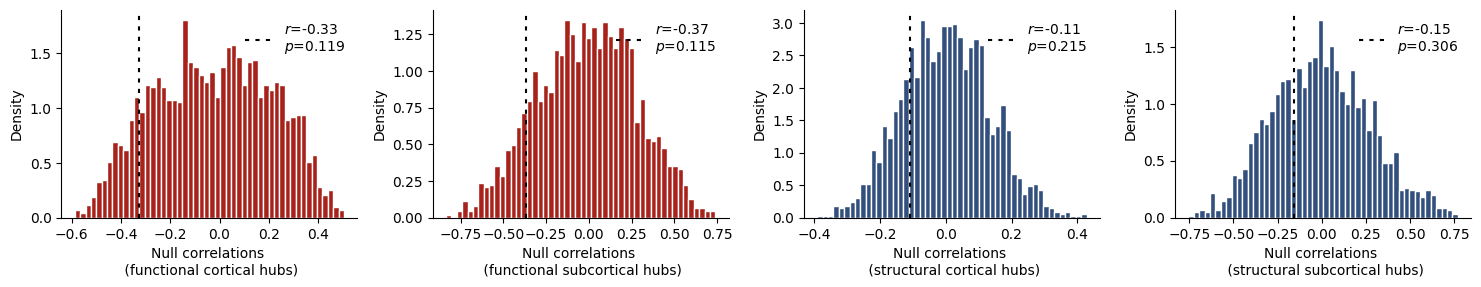

In [14]:
# we can also plot the null distributions of generated correlations

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(15, 3))

for k, (fn, dd) in enumerate(p_and_d.items()):
    # Define plot colors
    if k <= 1:
        col = '#A8221C'     # red for functional hubs
    else:
        col = '#324F7D'     # blue for structural hubs

    # Plot null distributions
    axs[k].hist(dd[1], bins=50, density=True, color=col, edgecolor='white', lw=0.5)
    axs[k].axvline(rvals[fn], lw=1.5, ls='--', color='k', dashes=(2, 3),
                   label='$r$={:.2f}'.format(rvals[fn]) + '\n$p$={:.3f}'.format(dd[0]))
    axs[k].set_xlabel('Null correlations \n ({})'.format(fn))
    axs[k].set_ylabel('Density')
    axs[k].spines['top'].set_visible(False)
    axs[k].spines['right'].set_visible(False)
    axs[k].legend(loc=1, frameon=False)

fig.tight_layout()
plt.show()

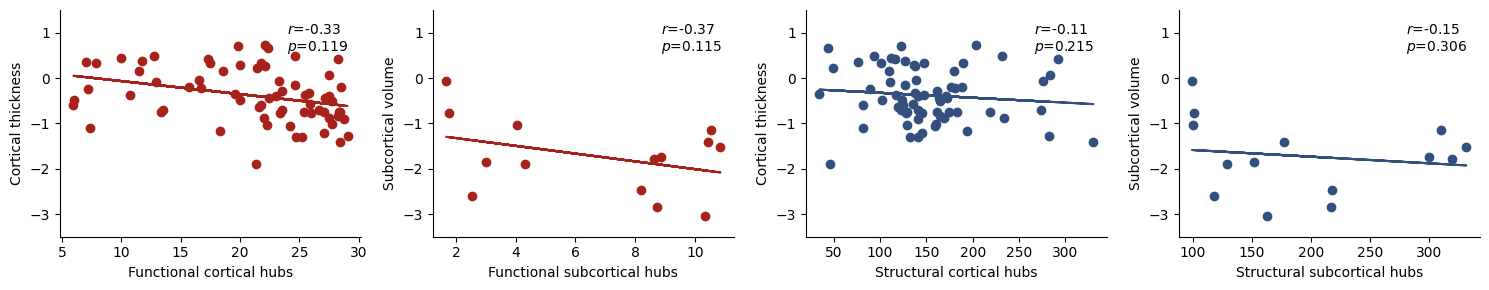

In [15]:
# plot hub-atrophy correlations 
import matplotlib.pyplot as plt

# Store degree centrality and atrophy measures
meas = {('functional cortical hubs', 'cortical thickness'): [fc_ctx_dc, CT_z_mean],
        ('functional subcortical hubs', 'subcortical volume'): [fc_sctx_dc, SV_z_mean_noVent],
        ('structural cortical hubs', 'cortical thickness'): [sc_ctx_dc, CT_z_mean],
        ('structural subcortical hubs', 'subcortical volume'): [sc_sctx_dc, SV_z_mean_noVent]}

fig, axs = plt.subplots(1, 4, figsize=(15, 3))

for k, (fn, dd) in enumerate(meas.items()):
    # Define scatter colors
    if k <= 1:
        col = '#A8221C'
    else:
        col = '#324F7D'

    # Plot relationships between hubs and atrophy
    axs[k].scatter(meas[fn][0], meas[fn][1], color=col,
                   label='$r$={:.2f}'.format(rvals[fn[0]]) + '\n$p$={:.3f}'.format(p_and_d[fn[0]][0]))
    m, b = np.polyfit(meas[fn][0], meas[fn][1], 1)
    axs[k].plot(meas[fn][0], m * meas[fn][0] + b, color=col)
    axs[k].set_ylim((-3.5, 1.5))
    axs[k].set_xlabel('{}'.format(fn[0].capitalize()))
    axs[k].set_ylabel('{}'.format(fn[1].capitalize()))
    axs[k].spines['top'].set_visible(False)
    axs[k].spines['right'].set_visible(False)
    axs[k].legend(loc=1, frameon=False, markerscale=0)

fig.tight_layout()
plt.show()

## Epicenter mapping 
### Cortical epicenters 


In [16]:
# Identify cortical epicenters (from functional connectivity)
fc_ctx_epi = []
fc_ctx_epi_p = []
for seed in range(fc_ctx.shape[0]):
    seed_con = fc_ctx[:, seed]
    fc_ctx_epi = np.append(fc_ctx_epi, np.corrcoef(seed_con, CT_z_mean)[0, 1])
    fc_ctx_epi_p = np.append(fc_ctx_epi_p,
                             spin_test(seed_con, CT_z_mean, surface_name='fsa5', parcellation_name='aparc',
                                       type='pearson', n_rot=1000, null_dist=False))

# Identify cortical epicenters (from structural connectivity)
sc_ctx_epi = []
sc_ctx_epi_p = []
for seed in range(sc_ctx.shape[0]):
    seed_con = sc_ctx[:, seed]
    sc_ctx_epi = np.append(sc_ctx_epi, np.corrcoef(seed_con, CT_z_mean)[0, 1])
    sc_ctx_epi_p = np.append(sc_ctx_epi_p,
                             spin_test(seed_con, CT_z_mean, surface_name='fsa5', parcellation_name='aparc',
                                       type='pearson', n_rot=1000, null_dist=False))

permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
permutation 100 of 1000
permutation 200 of 1000
permutation 300 of 1000
permutation 400 of 1000
permutation 500 of 1000
permutation 600 of 1000
permutation 700 of 1000
permutation 800 of 1000
permutation 900 of 1000
permutation 1000 of 1000
permutation 100 of 1000
permutation 

In [17]:
# Project the results on the surface brain
# Selecting only regions with p < 0.1 (functional epicenters)
fc_ctx_epi_p_sig = np.zeros_like(fc_ctx_epi_p)
fc_ctx_epi_p_sig[np.argwhere(fc_ctx_epi_p < 0.1)] = fc_ctx_epi[np.argwhere(fc_ctx_epi_p < 0.1)]
plot_cortical(array_name=parcel_to_surface(fc_ctx_epi_p_sig, 'aparc_fsa5'), surface_name="fsa5", size=(800, 400),
              cmap='GyRd_r', color_bar=True, color_range=(-0.5, 0.5))

# Selecting only regions with p < 0.1 (structural epicenters)
sc_ctx_epi_p_sig = np.zeros_like(sc_ctx_epi_p)
sc_ctx_epi_p_sig[np.argwhere(sc_ctx_epi_p < 0.1)] = sc_ctx_epi[np.argwhere(sc_ctx_epi_p < 0.1)]
plot_cortical(array_name=parcel_to_surface(sc_ctx_epi_p_sig, 'aparc_fsa5'), surface_name="fsa5", size=(800, 400),
              cmap='GyBu_r', color_bar=True, color_range=(-0.5, 0.5))

: 

### Subcortical epicenters 

In [1]:
# Identify subcortical epicenters (from functional connectivity)
fc_sctx_epi = []
fc_sctx_epi_p = []
for seed in range(fc_sctx.shape[0]):
    seed_con = fc_sctx[seed, :]
    fc_sctx_epi = np.append(fc_sctx_epi, np.corrcoef(seed_con, CT_z_mean)[0, 1])
    fc_sctx_epi_p = np.append(fc_sctx_epi_p,
                              spin_test(seed_con, CT_z_mean, surface_name='fsa5', n_rot=1000))

# Identify subcortical epicenters (from structural connectivity)
sc_sctx_epi = []
sc_sctx_epi_p = []
for seed in range(sc_sctx.shape[0]):
    seed_con = sc_sctx[seed, :]
    sc_sctx_epi = np.append(sc_sctx_epi, np.corrcoef(seed_con, CT_z_mean)[0, 1])
    sc_sctx_epi_p = np.append(sc_sctx_epi_p,
                              spin_test(seed_con, CT_z_mean, surface_name='fsa5', n_rot=1000))

NameError: name 'fc_sctx' is not defined

In [38]:
# Project the results on the surface brain
# Selecting only regions with p < 0.1 (functional epicenters)
fc_sctx_epi_p_sig = np.zeros_like(fc_sctx_epi_p)
fc_sctx_epi_p_sig[np.argwhere(fc_sctx_epi_p < 0.1)] = fc_sctx_epi[np.argwhere(fc_sctx_epi_p < 0.1)]
plot_subcortical(fc_sctx_epi_p_sig, ventricles=False, size=(800, 400),
                 cmap='GyRd_r', color_bar=True, color_range=(-0.5, 0.5))

# Selecting only regions with p < 0.1 (functional epicenters)
sc_sctx_epi_p_sig = np.zeros_like(sc_sctx_epi_p)
sc_sctx_epi_p_sig[np.argwhere(sc_sctx_epi_p < 0.1)] = sc_sctx_epi[np.argwhere(sc_sctx_epi_p < 0.1)]
plot_subcortical(sc_sctx_epi_p_sig, ventricles=False, size=(800, 400),
                 cmap='GyBu_r', color_bar=True, color_range=(-0.5, 0.5))

TypeError: '<' not supported between instances of 'list' and 'float'

# Test Neuromaps

table of contets: coordinate systems, brain maps and annotations, transformation between coordinates systems, comparing brain maps, spatial nulls of significance testing & generating automated reports 

maps: tags -> gens? functional, metabolism, ?

castrillon2023-cmrglc-MNI152-3mm

In [6]:
from enigmatoolbox.datasets import fetch_ahba

# Fetch gene expression data
genes = fetch_ahba()

# Obtain region labels
reglabels = genes['label']

# Obtain gene labels
genelabels = list(genes.columns)[1]

TypeError: read_csv() got an unexpected keyword argument 'error_bad_lines'. Did you mean 'on_bad_lines'?